In [31]:
import os
import timeit
import tarfile
from datetime import datetime, timedelta
from pathlib import Path
from types import SimpleNamespace
from glob import glob

import humanize
import matplotlib.pyplot as plt
import numpy as np
import pycdfpp
import cdflib
from spacepy import pycdf
import requests

SMALL_SIZE = 16
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

BENCHMARK_WORKDIR = f"{Path.home()}/cdf_benchmarks"

In [32]:
MASTERS_ULR="https://cdaweb.gsfc.nasa.gov/pub/software/cdawlib/0MASTERS/master.tar"

In [33]:
def download_file(url):
    fname = url.split("/")[-1]
    os.makedirs(BENCHMARK_WORKDIR, exist_ok=True)
    if not os.path.exists(f"{BENCHMARK_WORKDIR}/{fname}"):
        with open(f"{BENCHMARK_WORKDIR}/{fname}", "wb") as f:
            print(f"downloading {url}")
            f.write(requests.get(url).content)
    return fname

def is_compressed(fname):
    return (
        pycdfpp.load(fname).compression != pycdfpp.CompressionType.no_compression
    )


def file_size(fname):
    return os.stat(fname).st_size


def download_and_extract(url):
    tar_fname=download_file(MASTERS_ULR)
    tar = tarfile.open(f"{BENCHMARK_WORKDIR}/{tar_fname}")
    tar.extractall(path=f"{BENCHMARK_WORKDIR}/masters")
    tar.close()
    return f"{BENCHMARK_WORKDIR}/masters"

In [19]:
masters_dir=download_and_extract(MASTERS_ULR)
cdf_corpus = glob(f"{masters_dir}/*.cdf")
cdf_corpus_details = {
    fname: SimpleNamespace(
        size=file_size(fname),
        size_MB=file_size(fname) / 1000**2,
        is_compressed=is_compressed(fname),
    )
    for fname in cdf_corpus
}

In [64]:
class CdfLib:
    @staticmethod
    def just_open(fname):
        c = cdflib.CDF(fname)

    @staticmethod
    def list_variables(fname):
        c = cdflib.CDF(fname)
        cdf_info = c.cdf_info()
        variables = cdf_info.rVariables + cdf_info.zVariables

    @staticmethod
    def get_var_shape(fname, varname):
        shape = cdflib.CDF(fname).varinq(varname).Dim_Sizes

    @staticmethod
    def get_all_var_shapes(fname):
        c = cdflib.CDF(fname)
        cdf_info = c.cdf_info()
        variables = cdf_info.rVariables + cdf_info.zVariables
        [c.varinq(varname).Dim_Sizes for varname in variables]

    @staticmethod
    def get_var_data(fname, varname, ntimes=1):
        c = cdflib.CDF(fname)
        for _ in range(ntimes):
            values = c.varget(varname)

    @staticmethod
    def full_load(fname):
        c = cdflib.CDF(fname)
        cdf_info = c.cdf_info()
        variables = cdf_info.rVariables + cdf_info.zVariables
        [c.varget(varname) for varname in variables if c.varinq(varname).Last_Rec != -1]


class SpacePy:
    @staticmethod
    def just_open(fname):
        c = pycdf.CDF(fname)

    @staticmethod
    def list_variables(fname):
        variables = list(pycdf.CDF(fname))

    @staticmethod
    def get_var_shape(fname, varname):
        shape = pycdf.CDF(fname)[varname].shape

    @staticmethod
    def get_all_var_shapes(fname):
        c = pycdf.CDF(fname)
        [c[varname].shape for varname in c]

    @staticmethod
    def get_var_data(fname, varname, ntimes=1):
        c = pycdf.CDF(fname)
        for _ in range(ntimes):
            values = c[varname][:]

    @staticmethod
    def full_load(fname):
        c = pycdf.CDF(fname)
        [c.raw_var(varname)[:] for varname in c if len(c.raw_var(varname).shape)]
        # [c[varname][:] for varname in c if len(c.raw_var(varname).shape)]


class PyCdfPp:
    @staticmethod
    def just_open(fname):
        c = pycdfpp.load(fname)

    @staticmethod
    def list_variables(fname):
        variables = list(pycdfpp.load(fname))

    @staticmethod
    def get_var_shape(fname, varname):
        shape = pycdfpp.load(fname)[varname].shape

    @staticmethod
    def get_all_var_shapes(fname):
        c = pycdfpp.load(fname)
        [c[varname].shape for varname in c]

    @staticmethod
    def get_var_data(fname, varname, ntimes=1):
        c = pycdfpp.load(fname)
        for _ in range(ntimes):
            values = c[varname].values

    @staticmethod
    def full_load(fname):
        c = pycdfpp.load(fname)
        [c[varname].values for varname in c]


CDF_libs = {"CdfLib": CdfLib, "SpacePy": SpacePy, "PyCdfPp": PyCdfPp}

def bench_method(method, cdf_file, number=1000, **kwargs):
    return dict(
        sorted(
            [
                (
                    lib.__name__,
                    timeit.timeit(
                        lambda: getattr(lib, method)(cdf_file, **kwargs), number=number
                    )
                    / number,
                )
                for lib in (CdfLib, SpacePy, PyCdfPp)
            ],
            key=lambda item: item[1],
        )
    )

def plot_loghist(x, bins, label, alpha=1., edgecolor='black', linewidth=1.2):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins, label=label, alpha=alpha, edgecolor=edgecolor, linewidth=linewidth)
  plt.xscale('log')

In [36]:
just_open_results = {
    file: bench_method("just_open", file, number=10) for file in cdf_corpus
}

just_open_results

{'/home/jeandet/cdf_benchmarks/masters/solo_ll02_mag_00000000_v01.cdf': {'PyCdfPp': 6.432360005419469e-05,
  'CdfLib': 0.0001101265999750467,
  'SpacePy': 0.00012771850015269592},
 '/home/jeandet/cdf_benchmarks/masters/map_hl_pse_00000000_v01.cdf': {'CdfLib': 4.657240006054053e-05,
  'PyCdfPp': 0.00011400580006011296,
  'SpacePy': 0.00021648999991157324},
 '/home/jeandet/cdf_benchmarks/masters/i8_k0_pla_00000000_v01.cdf': {'CdfLib': 4.390440008137375e-05,
  'PyCdfPp': 9.768019990588072e-05,
  'SpacePy': 0.00015405899994220819},
 '/home/jeandet/cdf_benchmarks/masters/thg_l2_mag_jck_00000000_v01.cdf': {'CdfLib': 4.902300006506266e-05,
  'PyCdfPp': 5.452030000014929e-05,
  'SpacePy': 9.615839990146924e-05},
 '/home/jeandet/cdf_benchmarks/masters/mars_helio1day_position_00000000_v01.cdf': {'CdfLib': 4.623870008799713e-05,
  'PyCdfPp': 4.8764399980427695e-05,
  'SpacePy': 8.686090004630386e-05},
 '/home/jeandet/cdf_benchmarks/masters/fa_esa_l2_eeb_00000000_v01.cdf': {'PyCdfPp': 0.0002836640

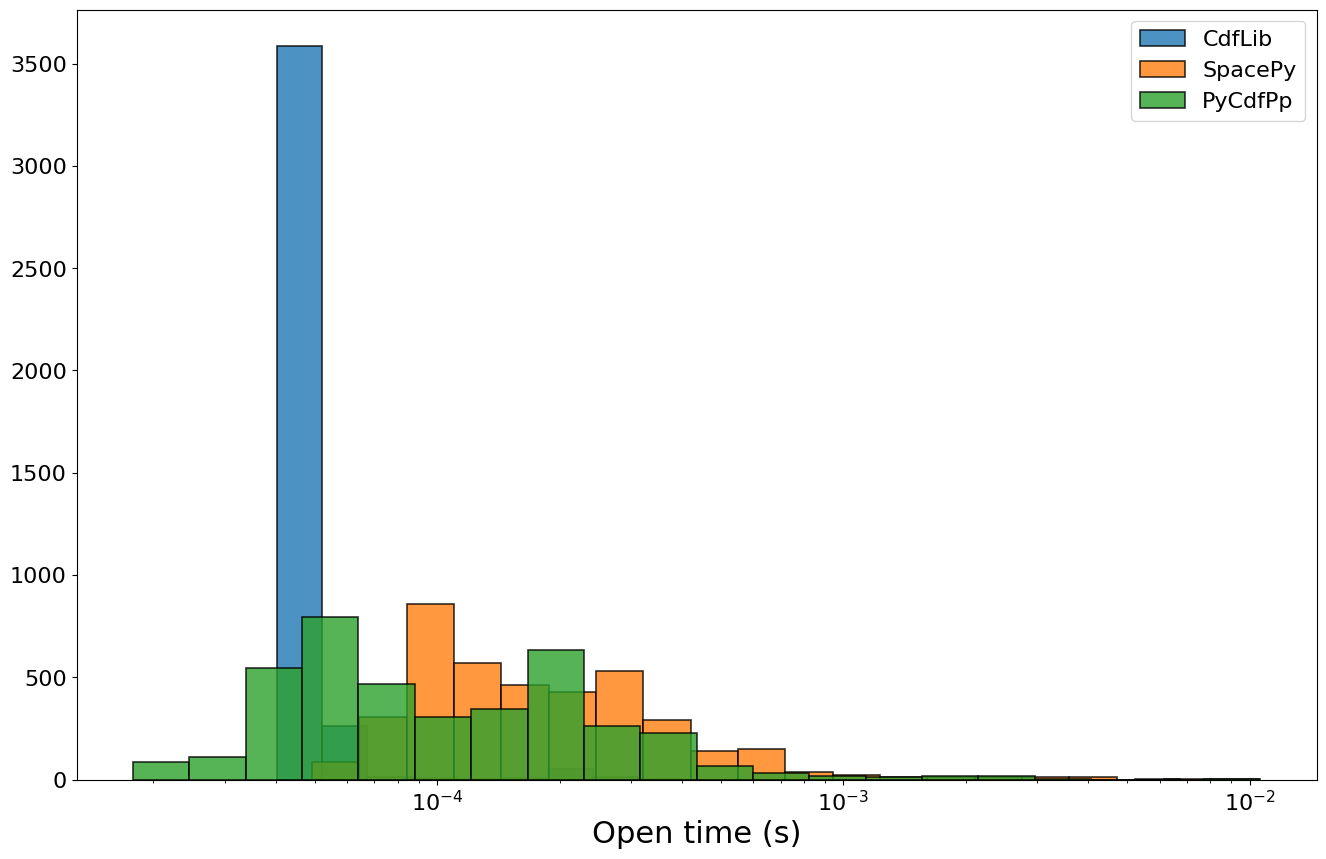

In [65]:
plt.figure(figsize=(16, 10))
for libname in CDF_libs.keys():
    plot_loghist([res[libname] for res in just_open_results.values()], bins=20, label=libname, alpha=0.8)

plt.xlabel("Open time (s)")
plt.suptitle("")
plt.legend(loc="upper right")
plt.show()

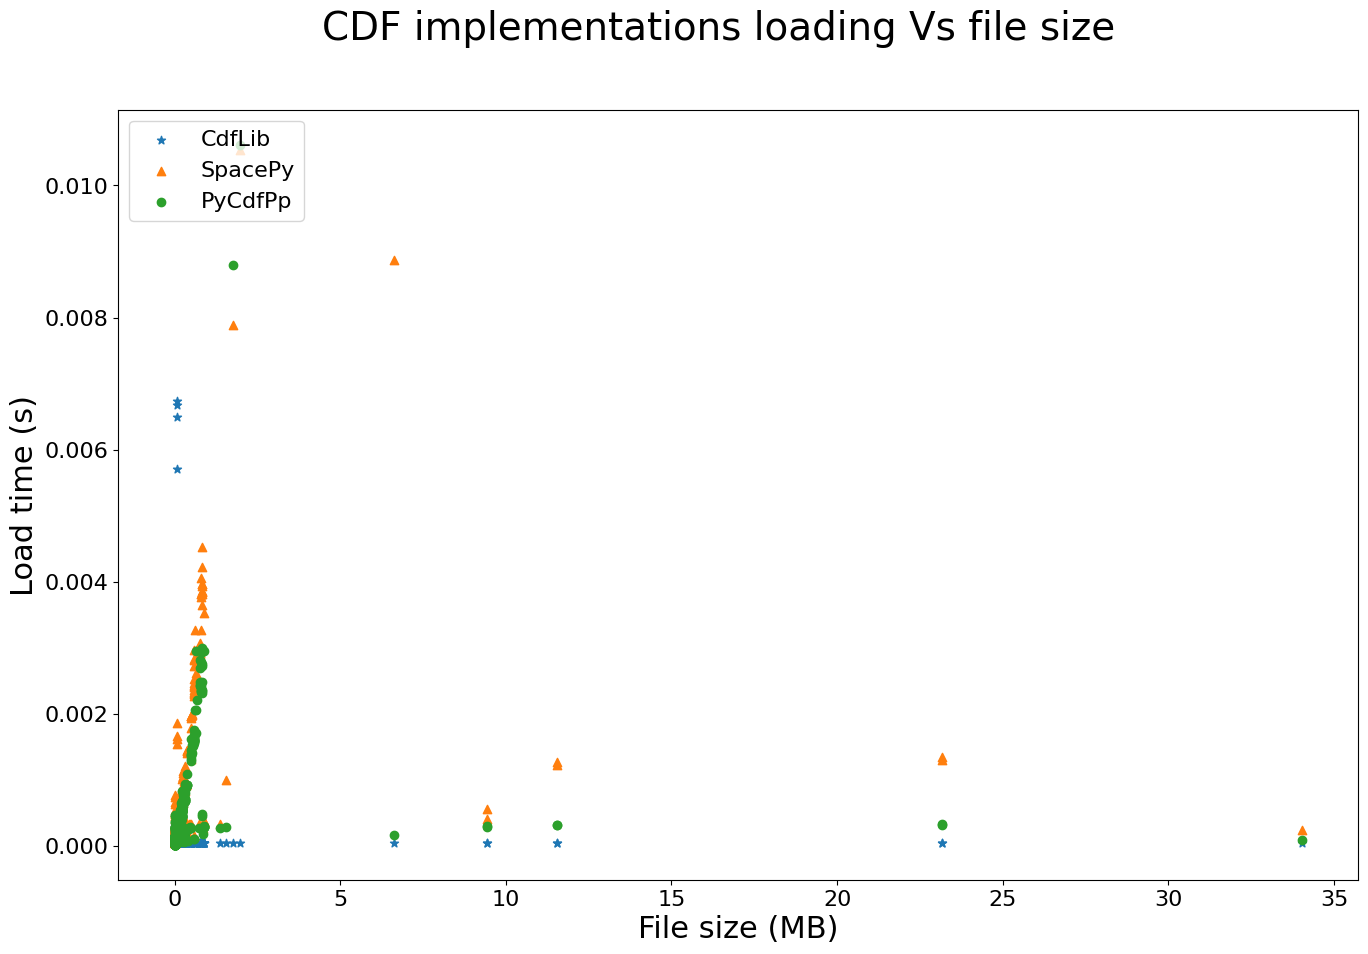

In [85]:
sizes = [cdf_corpus_details[f].size / 1024**2 for f in cdf_corpus]

plt.figure(figsize=(16, 10))
for marker, libname in zip(("*", "^", "o"), CDF_libs):
    plt.scatter(
        sizes,
        [res[libname] for res in just_open_results.values()],
        label=libname,
        marker=marker,
    )

plt.xlabel("File size (MB)")
plt.ylabel("Load time (s)")
plt.legend(loc="upper left")
plt.suptitle("CDF implementations loading Vs file size")
plt.show()

In [40]:
get_all_var_shapes_results = {
    file: bench_method("get_all_var_shapes", file, number=10) for file in cdf_corpus
}

get_all_var_shapes_results

{'/home/jeandet/cdf_benchmarks/masters/solo_ll02_mag_00000000_v01.cdf': {'PyCdfPp': 6.829209996794816e-05,
  'SpacePy': 0.0002936086999397958,
  'CdfLib': 0.0006873952001114958},
 '/home/jeandet/cdf_benchmarks/masters/map_hl_pse_00000000_v01.cdf': {'PyCdfPp': 0.0001635508000617847,
  'SpacePy': 0.0010137383000255796,
  'CdfLib': 0.0014790388999244898},
 '/home/jeandet/cdf_benchmarks/masters/i8_k0_pla_00000000_v01.cdf': {'PyCdfPp': 9.948759998223977e-05,
  'SpacePy': 0.0004887957000391907,
  'CdfLib': 0.0006576755000423873},
 '/home/jeandet/cdf_benchmarks/masters/thg_l2_mag_jck_00000000_v01.cdf': {'PyCdfPp': 7.148599997890415e-05,
  'SpacePy': 0.0002860173999579274,
  'CdfLib': 0.0005830764999700478},
 '/home/jeandet/cdf_benchmarks/masters/mars_helio1day_position_00000000_v01.cdf': {'PyCdfPp': 5.744379996031057e-05,
  'SpacePy': 0.0002190749000874348,
  'CdfLib': 0.0004635354000129155},
 '/home/jeandet/cdf_benchmarks/masters/fa_esa_l2_eeb_00000000_v01.cdf': {'PyCdfPp': 0.000324513600025

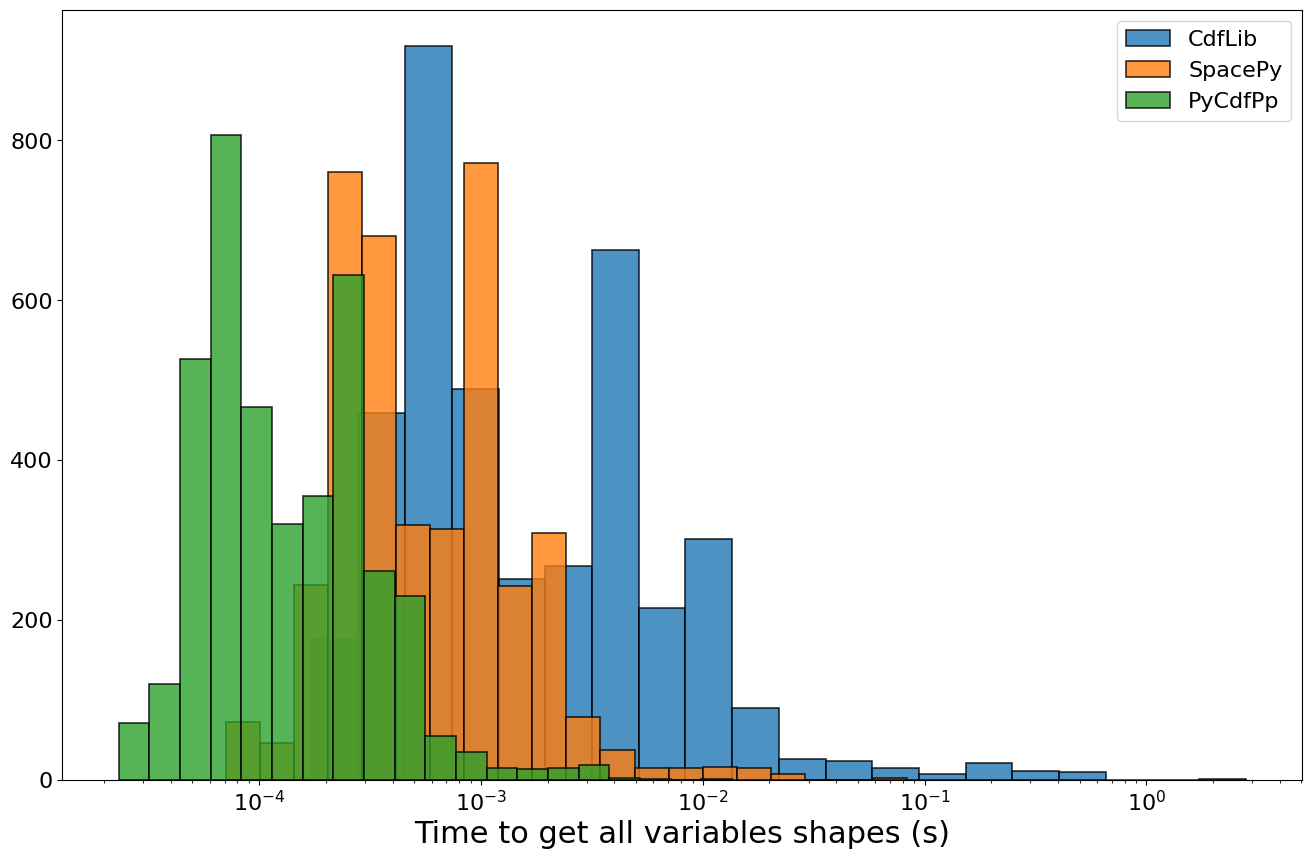

In [66]:
plt.figure(figsize=(16, 10))
for libname in CDF_libs.keys():
    plot_loghist([res[libname] for res in get_all_var_shapes_results.values()], bins=20, label=libname, alpha=0.8)


plt.xlabel("Time to get all variables shapes (s)")
plt.suptitle("")
plt.legend(loc="upper right")
plt.show()

In [72]:
slowest = None
for fname, result in just_open_results.items():
    t = result['PyCdfPp']
    if slowest is None or slowest[1] < t:
        slowest = (fname, t)


In [73]:
slowest

('/home/jeandet/cdf_benchmarks/masters/psp_fld_l2_rfs_lfr_00000000_v01.cdf',
 0.010616069800016703)

In [78]:
sorted(map(lambda f:(f.split('/')[-1],len(pycdfpp.load(f))), cdf_corpus), key=lambda r: r[1], reverse=True)

[('psp_fld_l2_rfs_lfr_00000000_v01.cdf', 1524),
 ('psp_fld_l2_rfs_hfr_00000000_v01.cdf', 1356),
 ('psp_fld_l2_rfs_burst_00000000_v01.cdf', 684),
 ('psp_fld_l3_rfs_lfr_00000000_v01.cdf', 623),
 ('mms4_epd-eis_srvy_l2_extof_00000000_v01.cdf', 604),
 ('mms3_epd-eis_brst_l2_extof_00000000_v01.cdf', 604),
 ('mms4_epd-eis_brst_l2_extof_00000000_v01.cdf', 604),
 ('mms2_epd-eis_brst_l2_extof_00000000_v01.cdf', 604),
 ('mms1_epd-eis_srvy_l2_extof_00000000_v01.cdf', 604),
 ('mms1_epd-eis_brst_l2_extof_00000000_v01.cdf', 604),
 ('mms2_epd-eis_srvy_l2_extof_00000000_v01.cdf', 604),
 ('mms3_epd-eis_srvy_l2_extof_00000000_v01.cdf', 604),
 ('thd_l2_fft_00000000_v01.cdf', 541),
 ('thc_l2_fft_00000000_v01.cdf', 541),
 ('the_l2_fft_00000000_v01.cdf', 541),
 ('thb_l2_fft_00000000_v01.cdf', 541),
 ('tha_l2_fft_00000000_v01.cdf', 541),
 ('psp_fld_l3_rfs_hfr_00000000_v01.cdf', 511),
 ('solo_l2_swa-his-hk_00000000_v01.cdf', 499),
 ('tss-1r_m1_rtmc_00000000_v01.cdf', 446),
 ('tss-1r_m1_rtmf_00000000_v01.cdf',

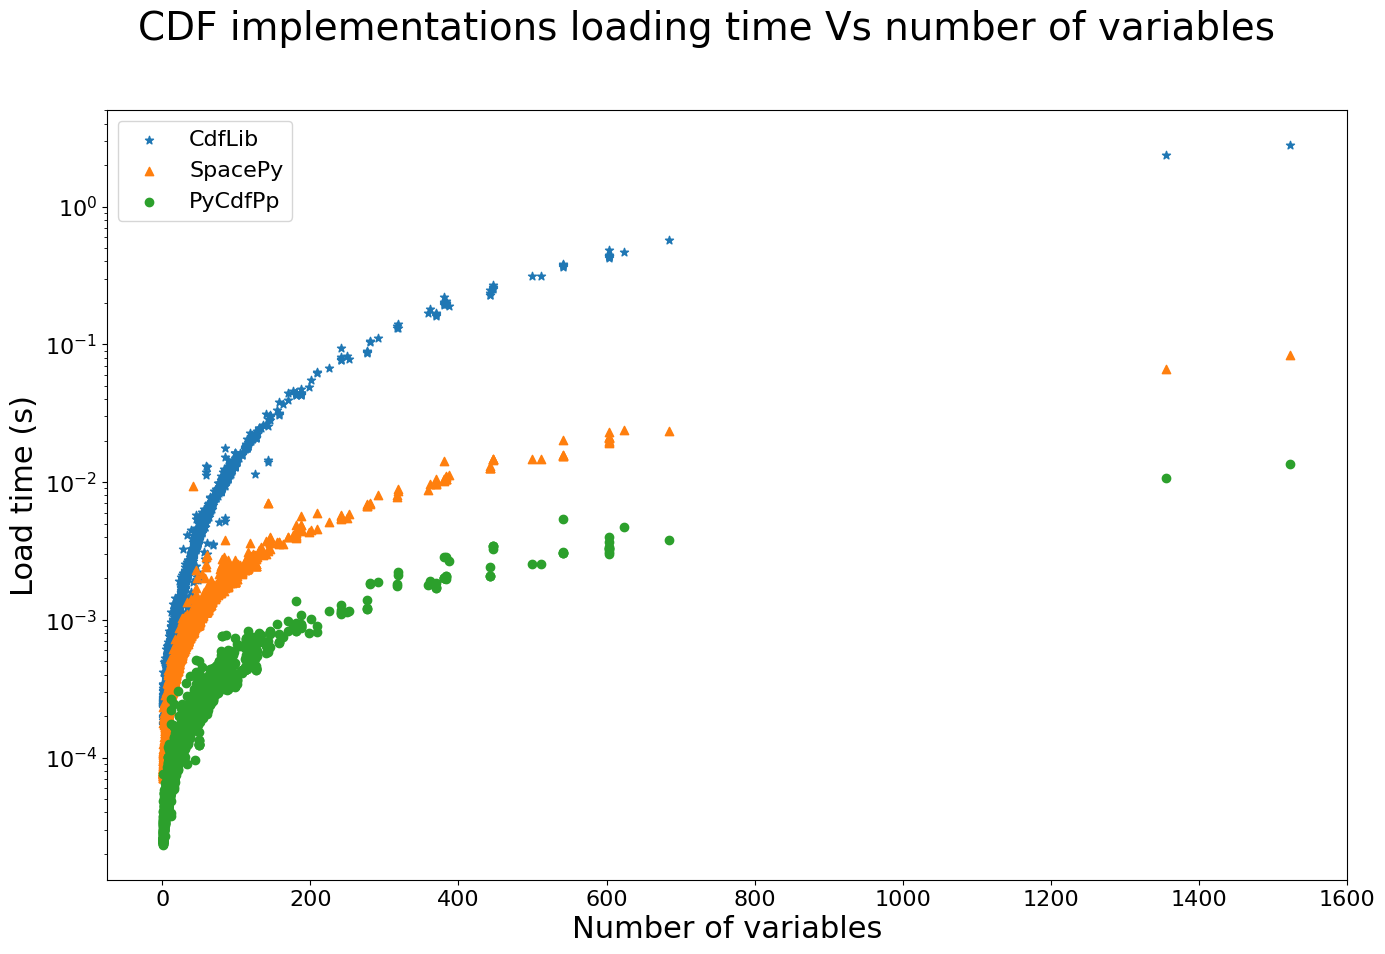

In [83]:
var_count = [len(pycdfpp.load(f)) for f in cdf_corpus]

plt.figure(figsize=(16, 10))
for marker, libname in zip(("*", "^", "o"), CDF_libs):
    plt.scatter(
        var_count,
        [res[libname] for res in get_all_var_shapes_results.values()],
        label=libname,
        marker=marker,
    )

plt.xlabel("Number of variables")
plt.ylabel("Load time (s)")
plt.legend(loc="upper left")
plt.semilogy()
plt.suptitle("CDF implementations loading time Vs number of variables")
plt.show()

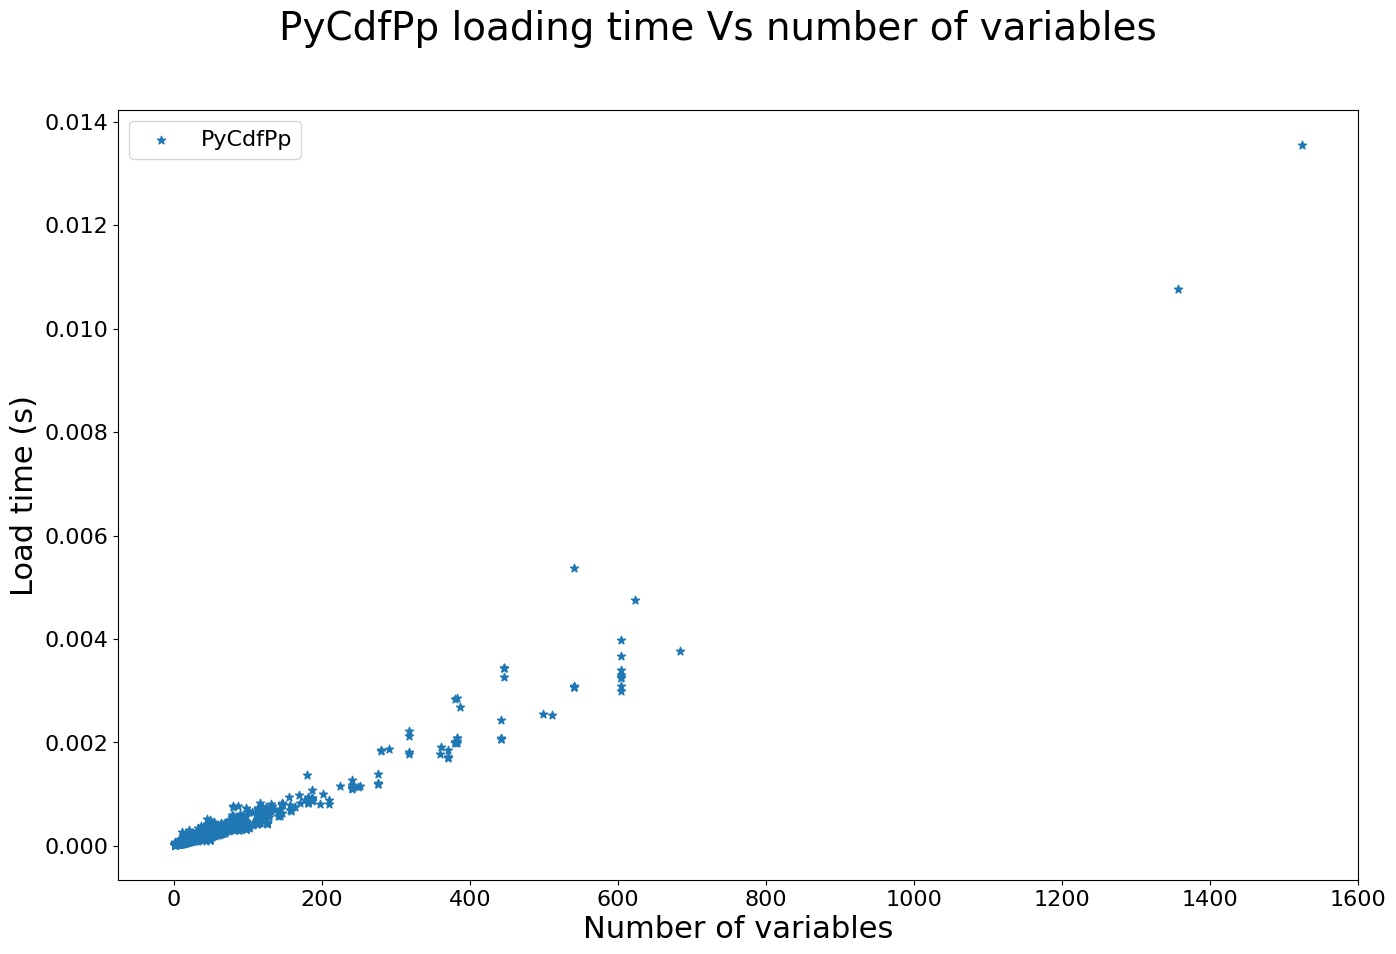

In [87]:
var_count = [len(pycdfpp.load(f)) for f in cdf_corpus]

plt.figure(figsize=(16, 10))
for marker, libname in zip(("*",), ("PyCdfPp",)):
    plt.scatter(
        var_count,
        [res[libname] for res in get_all_var_shapes_results.values()],
        label=libname,
        marker=marker,
    )

plt.xlabel("Number of variables")
plt.ylabel("Load time (s)")
plt.legend(loc="upper left")

plt.suptitle("PyCdfPp loading time Vs number of variables")
plt.show()